In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.covariance import OAS, LedoitWolf
import cvxpy as cp
import warnings


np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
warnings.filterwarnings('ignore')

##**Step 2**

In [2]:
def retrieve_historical_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    returns = data.pct_change().dropna()
    return data,returns

In [3]:
tickers = ['AAPL', 'JNJ', 'V', 'PG', 'XOM']
start_date = '2020-01-01'
end_date = '2021-09-01'

data,returns = retrieve_historical_data(tickers, start_date, end_date)

[*********************100%%**********************]  5 of 5 completed


### **Tangency**

In [4]:
def get_weights_tangency(returns):
    n_assets = returns.shape[1]
    cov_matrix = returns.cov()
    weights_mvp = cp.Variable(n_assets)
    returns_mvp = np.array(returns.mean()) @ weights_mvp
    risk_mvp = cp.quad_form(weights_mvp, np.array(returns.cov()))
    objective_mvp = cp.Minimize(risk_mvp)
    constraints_mvp = [cp.sum(weights_mvp) == 1, weights_mvp >= 0]
    problem_mvp = cp.Problem(objective_mvp, constraints_mvp)
    problem_mvp.solve(solver='ECOS_BB')
    min_returns = np.dot(returns.mean(), weights_mvp.value)
    max_returns = np.max(returns.mean())
    n_points = 10
    optimal_weights = np.zeros((n_points, n_assets))
    optimal_returns = np.linspace(min_returns, max_returns, n_points)
    optimal_risk = np.zeros(n_points)

    for i, exp_return in enumerate(optimal_returns):
        weights_ef = cp.Variable(n_assets)
        returns_ef = np.array(returns.mean()) @ weights_ef
        risk_ef = cp.quad_form(weights_ef, returns.cov())
        objective = cp.Minimize(1/2 * risk_ef - returns_ef)
        constraints = [cp.sum(weights_ef) == 1, weights_ef >= 0, returns_ef <= exp_return]

        problem = cp.Problem(objective, constraints)
        problem.solve(solver='ECOS_BB')

        if weights_ef.value is not None:
                optimal_weights[i] = weights_ef.value.flatten()
                optimal_risk[i] = np.sqrt(np.dot(weights_ef.value.T, np.dot(cov_matrix, weights_ef.value)))

    sharpe_ratios = optimal_returns / optimal_risk
    max_sharpe = np.argmax(sharpe_ratios)
    return optimal_weights[max_sharpe], np.max(sharpe_ratios)

In [5]:
tangency_weight, tangency_sharpe = get_weights_tangency(returns)

In [6]:
tangency_sharpe,tangency_weight

(0.08096031582141958,
 array([0.99999993, 0.00000002, 0.00000002, 0.00000002, 0.00000001]))

### **Equally-weighted**

In [7]:
def get_weights_equal(returns):
    weights = np.array([1 / returns.shape[1]] * returns.shape[1])
    mean_returns = np.sum(returns.mean() * weights)
    risk = np.sqrt(np.dot(weights, np.dot(returns.cov(), weights)))
    return weights, mean_returns / risk

In [8]:
equal_weights, equal_weights_sr = get_weights_equal(returns)

In [9]:
equal_weights_sr, equal_weights

(0.046607128218732884, array([0.2, 0.2, 0.2, 0.2, 0.2]))

### **Denoising**

In [10]:
def covariance_shrinkage(returns, method):
    if method=='oas':
        cov_matrix = OAS().fit(returns).covariance_
    if method=='lw':
        cov_matrix = LedoitWolf().fit(returns).covariance_
    return cov_matrix

In [11]:
def get_weights_denoising(returns, shrinkage=None, method=None):
    if method==None:
        corr = returns.corr()
        shrunk_corr = ((1 - shrinkage) * corr) + (shrinkage * np.identity(corr.shape[0]))
        std_matrix = np.diag(returns.std())
        cov_matrix = np.matmul(std_matrix, np.matmul(shrunk_corr, std_matrix))
    else:
        cov_matrix = covariance_shrinkage(returns, method=method)
    n_assets = returns.shape[1]
    weights_mvp = cp.Variable(n_assets)
    returns_mvp = np.array(returns.mean()) @ weights_mvp
    risk_mvp = cp.quad_form(weights_mvp, cov_matrix)
    objective_mvp = cp.Minimize(risk_mvp)
    constraints_mvp = [cp.sum(weights_mvp) == 1, weights_mvp >= 0]
    problem_mvp = cp.Problem(objective_mvp, constraints_mvp)
    problem_mvp.solve(solver='ECOS_BB')
    min_returns = np.dot(returns.mean(), weights_mvp.value)
    max_returns = np.max(returns.mean())
    n_points = 10
    optimal_weights = np.zeros((n_points, n_assets))
    optimal_returns = np.linspace(min_returns, max_returns, n_points)
    optimal_risk = np.zeros(n_points)

    for i, exp_return in enumerate(optimal_returns):
        weights_ef = cp.Variable(n_assets)
        returns_ef = np.array(returns.mean()) @ weights_ef
        risk_ef = cp.quad_form(weights_ef, cov_matrix)
        objective = cp.Minimize(1/2 * risk_ef - returns_ef)
        constraints = [cp.sum(weights_ef) == 1, weights_ef >= 0, returns_ef <= exp_return]

        problem = cp.Problem(objective, constraints)
        problem.solve(solver='ECOS_BB')

        if weights_ef.value is not None:
                optimal_weights[i] = weights_ef.value.flatten()
                optimal_risk[i] = np.sqrt(np.dot(weights_ef.value.T, np.dot(cov_matrix, weights_ef.value)))

    sharpe_ratios = optimal_returns / optimal_risk
    max_sharpe = np.argmax(sharpe_ratios)
    return optimal_weights[max_sharpe], np.max(sharpe_ratios)

In [12]:
optimal_shrinkage = []

training_period = 30
testing_period = 10

for i in range(0, len(returns) - training_period - testing_period, testing_period):
    training_data = returns.iloc[i: i + training_period]
    testing_data = returns.iloc[i + training_period: i + training_period + testing_period]
    sharpe = []
    for i in np.linspace(0, 1, 10):
        weights, ds = get_weights_denoising(returns, shrinkage=i)
        test_ret = np.sum(testing_data * weights, axis=1)
        test_sharpe = test_ret.mean() / test_ret.std()
        sharpe.append((i, test_sharpe))
    optimal_shrinkage.append(sorted(sharpe, key=lambda x: x[1], reverse=True)[0][0])

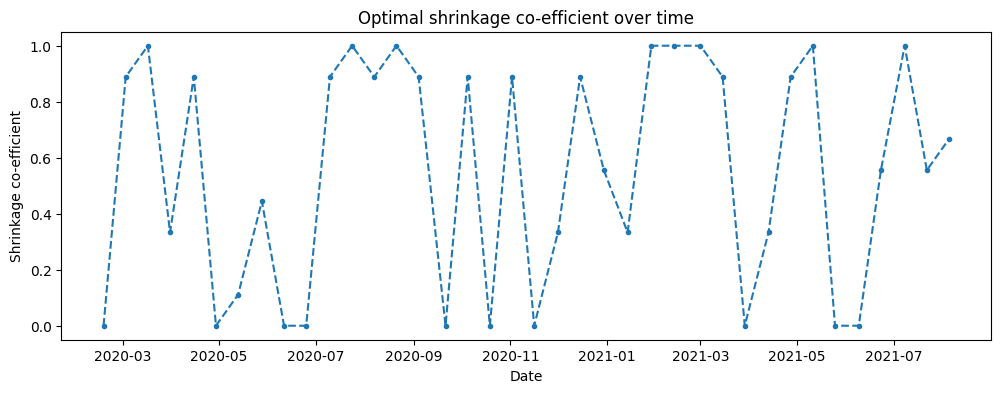

In [13]:
fig, axis = plt.subplots(figsize=(12, 4))
plt.plot(pd.Series(optimal_shrinkage, index=returns.index[training_period::testing_period][:-1]), '.--')
plt.ylabel('Shrinkage co-efficient')
plt.xlabel('Date')
plt.title('Optimal shrinkage co-efficient over time');

In [14]:
denoising_weights, denoising_sharpe = get_weights_denoising(returns, method='lw')

In [15]:
denoising_sharpe, denoising_weights

(0.08149670071277362,
 array([0.99999989, 0.00000003, 0.00000003, 0.00000003, 0.00000002]))

### **Clustering**

In [16]:
def distance(x, y):
    corr = np.corrcoef(x, y)[0, 1]
    return np.sqrt(2 * (1 - corr))

def get_optimal_k(returns):
    distance_matrix = pairwise_distances(returns.T, metric=distance)
    np.fill_diagonal(distance_matrix, 0)
    silhouette_scores = []
    for i in range(2, returns.shape[1]):
        model = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage='complete')
        pred = model.fit_predict(distance_matrix)
        silhouette_scores.append(silhouette_score(distance_matrix, labels=pred, metric='precomputed'))
    return np.argmax(silhouette_scores) + 2

def get_weights_clustering(returns):
    weights = np.zeros(returns.shape[1])
    opt_k = get_optimal_k(returns)
    distance_matrix = pairwise_distances(returns.T, metric=distance)
    np.fill_diagonal(distance_matrix, 0)
    linkage_matrix = shc.linkage(distance_matrix, method='complete')
    weights_l = []

    for i in range(opt_k):
        ct = shc.cut_tree(linkage_matrix, n_clusters=i+1).flatten()
        weights_l.append(ct)

    tot_weight = 1
    for i in range(len(weights_l) - 1):
        idx = np.where((weights_l[i] == 0) & (weights_l[i+1] != 0), 1, 0)
        split = tot_weight / 2
        try:
            weights[np.where(idx==1)[0]] = split / np.where(idx==1)[0].shape[0]
        except:
            continue
        tot_weight = split
    weights[np.where(weights==0)] = split / np.where(weights==0)[0].shape[0]
    weights/=sum(weights)

     # Calculate portfolio returns
    portfolio_returns = np.dot(returns, weights)

    # Calculate portfolio standard deviation
    portfolio_std_dev = np.std(portfolio_returns)

    # Calculate Sharpe ratio
    sharpe_ratio = (np.mean(portfolio_returns)) / portfolio_std_dev

    return weights, sharpe_ratio

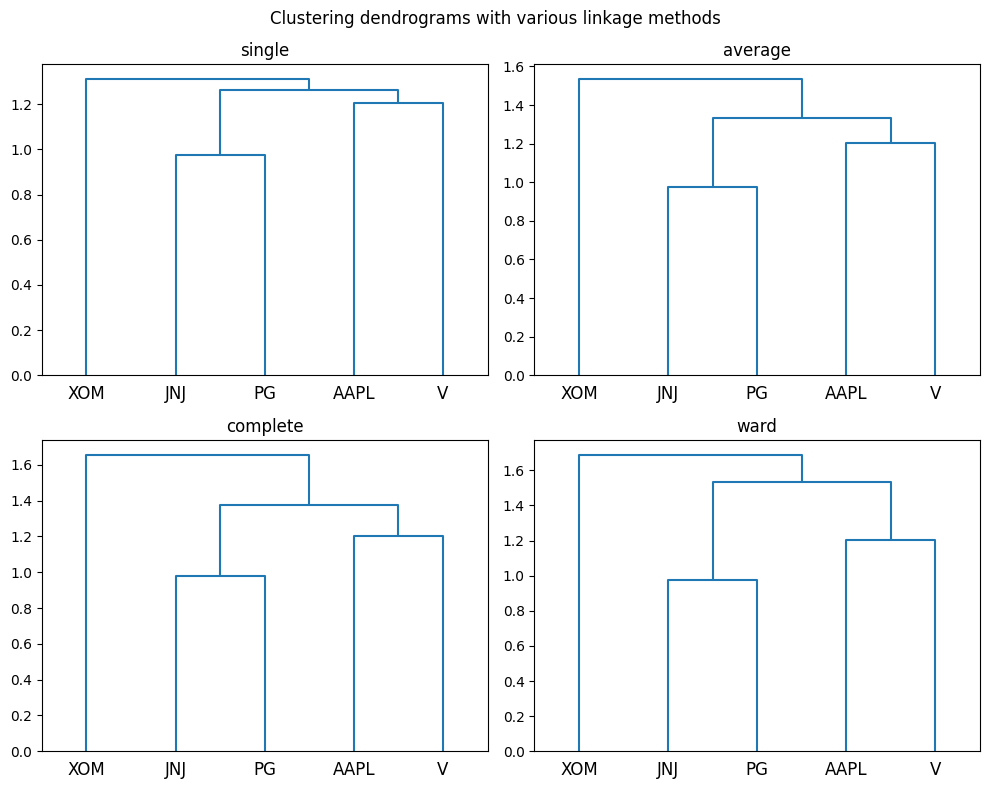

In [17]:
distance_matrix = pairwise_distances(returns.T, metric=distance)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, j in enumerate(['single', 'average', 'complete', 'ward']):
    shc.dendrogram(shc.linkage(distance_matrix, method=j), labels=returns.columns, ax=ax[i // 2, i % 2], color_threshold=0.8)
    ax[i // 2, i % 2].set_title(j)

plt.suptitle('Clustering dendrograms with various linkage methods')
plt.tight_layout()
plt.show()


In [18]:
clustering_weights, clustering_sr = get_weights_clustering(returns)

clustering_sr, clustering_weights

(0.02648519205907584, array([0.125, 0.125, 0.125, 0.125, 0.5  ]))

### **BackTesting**

In [19]:
def get_weights_sharpe_tangency(returns):
    n_assets = returns.shape[1]
    cov_matrix = returns.cov()
    weights_mvp = cp.Variable(n_assets)
    returns_mvp = np.array(returns.mean()) @ weights_mvp
    risk_mvp = cp.quad_form(weights_mvp, np.array(returns.cov()))
    objective_mvp = cp.Minimize(risk_mvp)
    constraints_mvp = [cp.sum(weights_mvp) == 1, weights_mvp >= 0]
    problem_mvp = cp.Problem(objective_mvp, constraints_mvp)
    problem_mvp.solve(solver='ECOS_BB')
    min_returns = np.dot(returns.mean(), weights_mvp.value)
    max_returns = np.max(returns.mean())
    n_points = 10
    optimal_weights = np.zeros((n_points, n_assets))
    optimal_returns = np.linspace(min_returns, max_returns, n_points)
    optimal_risk = np.zeros(n_points)

    for i, exp_return in enumerate(optimal_returns):
        weights_ef = cp.Variable(n_assets)
        returns_ef = np.array(returns.mean()) @ weights_ef
        risk_ef = cp.quad_form(weights_ef, returns.cov())
        objective = cp.Minimize(1/2 * risk_ef - returns_ef)
        constraints = [cp.sum(weights_ef) == 1, weights_ef >= 0, returns_ef <= exp_return]

        problem = cp.Problem(objective, constraints)
        problem.solve(solver='ECOS_BB')

        if weights_ef.value is not None:
                optimal_weights[i] = weights_ef.value.flatten()
                optimal_risk[i] = np.sqrt(np.dot(weights_ef.value.T, np.dot(cov_matrix, weights_ef.value)))

    sharpe_ratios = optimal_returns / optimal_risk
    max_sharpe = np.argmax(sharpe_ratios)
    return optimal_weights[max_sharpe], np.max(sharpe_ratios)

In [20]:
# Define parameters
training_period_length = 30  # 180 trading days (approximately 6 months)
testing_period_length =  10  # 90 trading days (approximately 3 months)
sharpe_ratios = []
dates = []
backtesting_weights = pd.DataFrame(columns=tickers)

#### **Sharpe Ratio**

In [21]:
def backtest_returns(returns, training_period_length, testing_period_length):
    sharpe_ratios = []
    dates = []
    backtesting_weights = pd.DataFrame(columns=returns.columns)  # Initialize DataFrame to store backtesting weights

    for i in range(0, len(returns) - training_period_length - testing_period_length, testing_period_length):
        # Split data into training and testing periods
        training_data = returns.iloc[i:i+training_period_length]
        testing_data = returns.iloc[i+training_period_length:i+training_period_length+testing_period_length]

        # Generate random portfolios and find portfolio with highest Sharpe ratio
        weights, sharpe_ratio = get_weights_sharpe_tangency(training_data)

        # Apply optimized strategy to testing data
        backtesting_weights.loc[training_data.index[-1]] = weights

        # Record results
        sharpe_ratios.append(sharpe_ratio)
        dates.append(testing_data.index[-1])  # Using the last date of testing period

    # Convert lists to numpy arrays
    sharpe_ratios = np.array(sharpe_ratios)
    dates = np.array(dates)

    return sharpe_ratios, dates, backtesting_weights

In [22]:
def plot_sharpe_ratio(dates, sharpe_ratios):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, sharpe_ratios, marker='o', linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.title('Sharpe Ratio vs. Date')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


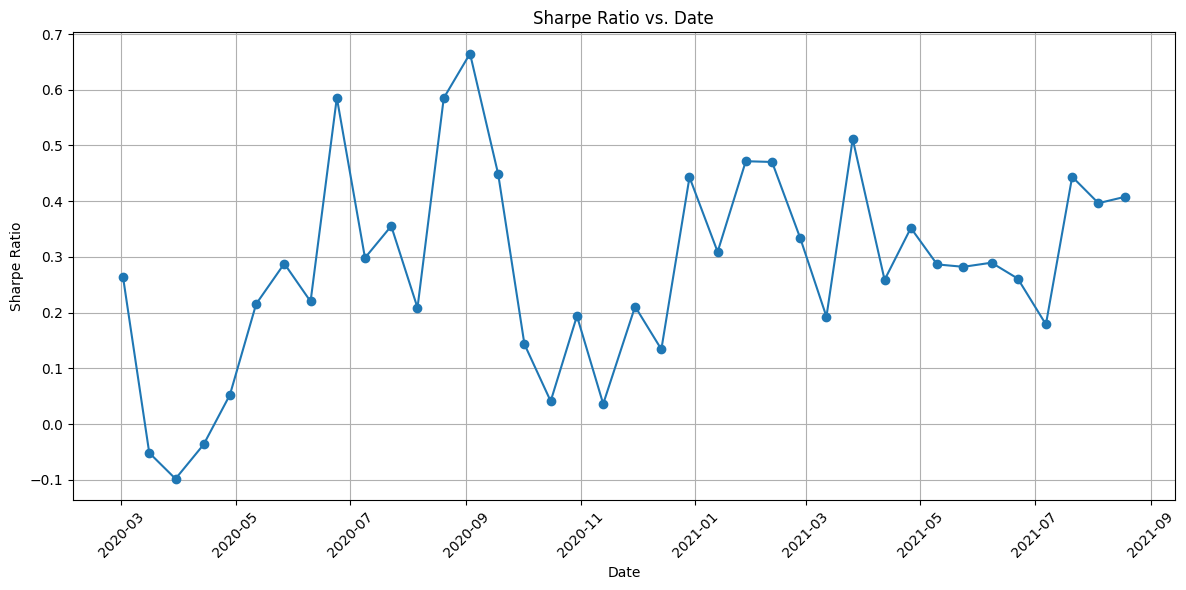

Average Sharpe Ratio: 0.28022981816347764


In [23]:
sharpe_ratios, dates, backtesting_weights = backtest_returns(returns, training_period_length, testing_period_length)

plot_sharpe_ratio(dates, sharpe_ratios)
# Final evaluation
average_sharpe_ratio = np.mean(sharpe_ratios)
print("Average Sharpe Ratio:", average_sharpe_ratio)

<Figure size 600x400 with 0 Axes>

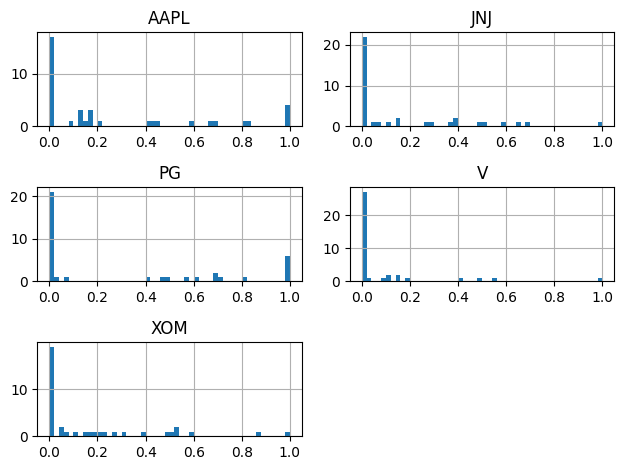

In [24]:
plt.figure(figsize=(6, 4))
backtesting_weights.hist(bins=50)
plt.xlabel('Weights')
plt.ylabel('Frequency')
plt.title('Histogram of Weights')
plt.tight_layout()
plt.show()

In [25]:
bt_weight_stats = backtesting_weights.describe()
bt_weight_stats

,AAPL,JNJ,PG,V,XOM
count,38.00000,38.00000,38.00000,38.00000,38.00000
mean,0.26983,0.16220,0.30404,0.08670,0.17723
std,0.35341,0.25508,0.40027,0.20473,0.26017
min,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.12923,0.00000,0.00000,0.00000,0.02400
75%,0.45170,0.28731,0.66502,0.08089,0.26821
max,1.00000,1.00000,1.00000,1.00000,1.00000


In [26]:
sum_of_mean_weights = bt_weight_stats.loc['mean'].sum()
sum_of_mean_weights

0.9999999999999913

#### **MaxDrawdown**

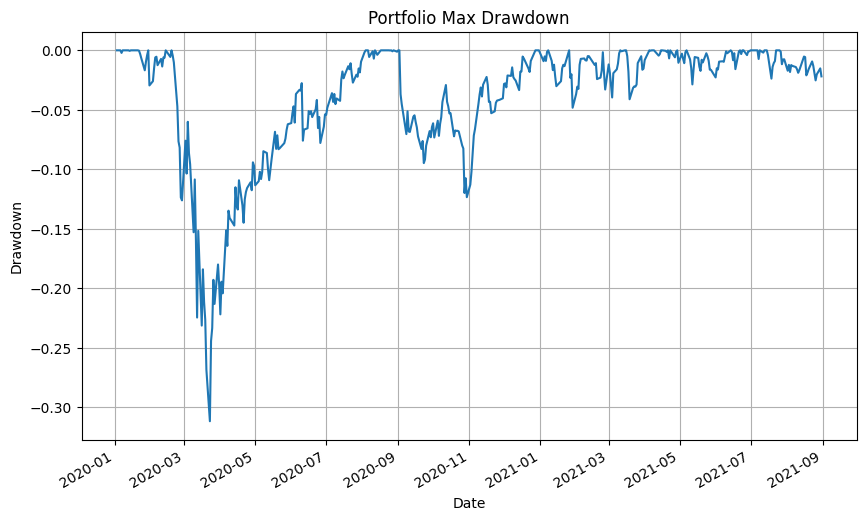

In [27]:

portfolio_value = data.sum(axis=1)
portfolio_returns = portfolio_value.pct_change()
portfolio_cumulative_returns = (portfolio_returns + 1).cumprod()

# Step 6: Calculate drawdown
rolling_max = portfolio_cumulative_returns.cummax()
drawdown = (portfolio_cumulative_returns - rolling_max) / rolling_max

# Plot the drawdown
plt.figure(figsize=(10, 6))
drawdown.plot()
plt.title('Portfolio Max Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()


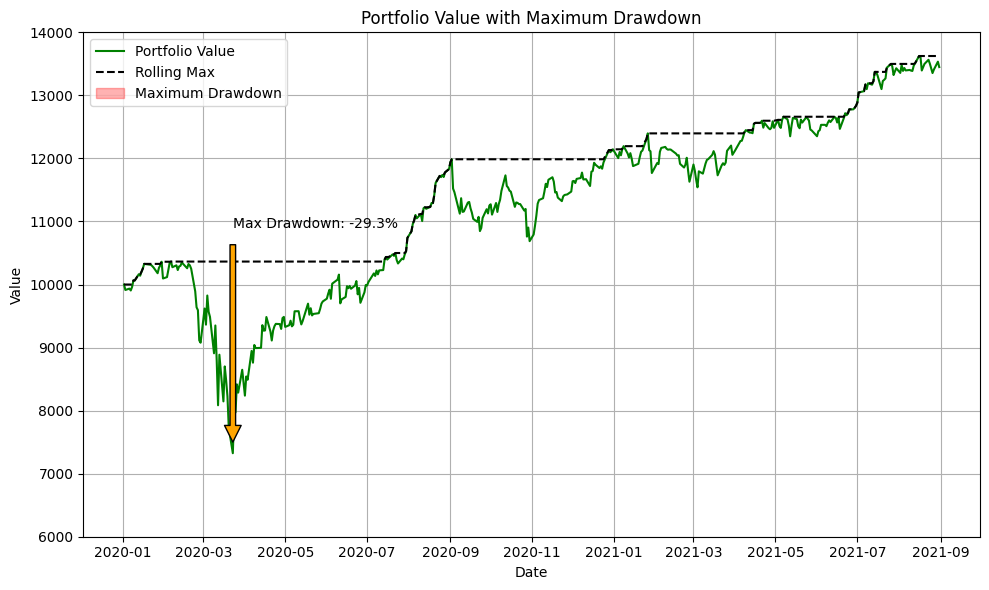

In [28]:


# Calculate portfolio value with equal weights
portfolio_value = (data * backtesting_weights.mean()).sum(axis=1)
initial_investment = 10000
portfolio_value *= initial_investment / portfolio_value.iloc[0]  # Adjust to initial investment of $10,000

# Calculate maximum drawdown
rolling_max_portfolio = portfolio_value.cummax()
daily_drawdown_portfolio = portfolio_value / rolling_max_portfolio - 1.0
max_drawdown_portfolio = daily_drawdown_portfolio.cummin()

# Find the maximum drawdown value and its date range
max_drawdown_value_portfolio = max_drawdown_portfolio.min()
max_drawdown_start_date_portfolio = max_drawdown_portfolio.idxmin()
max_drawdown_end_date_portfolio = portfolio_value.loc[max_drawdown_portfolio.idxmin():].idxmax()

# Plot portfolio value and maximum drawdown
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value, label='Portfolio Value', color='green')
plt.plot(rolling_max_portfolio, 'k--', label='Rolling Max')
plt.fill_between(portfolio_value.index, 0, max_drawdown_portfolio, color='red', alpha=0.3, label='Maximum Drawdown')
plt.title('Portfolio Value with Maximum Drawdown')
plt.xlabel('Date')
plt.ylabel('Value')
plt.ylim(6000, 14000)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate maximum drawdown value and date range
plt.annotate(f'Max Drawdown: {max_drawdown_value_portfolio*100:.1f}%',
             xy=(max_drawdown_start_date_portfolio, portfolio_value.loc[max_drawdown_start_date_portfolio]),
             xytext=(max_drawdown_start_date_portfolio, portfolio_value.max()*0.8),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             )

plt.show()


In [29]:
window_size = 30
step_size = 10
max_drawdown_values = []
max_drawdown_start_dates = []
max_drawdown_end_dates = []

# Perform walk-forward backtesting
for i in range(0, len(data) - window_size, step_size):

    window_data = data.iloc[i:i+window_size]

    # Calculate portfolio value with equal weights
    portfolio_value = (window_data * backtesting_weights.mean()).sum(axis=1)
    initial_investment = 10000
    portfolio_value *= initial_investment / portfolio_value.iloc[0]  # Adjust to initial investment of $10,000

    # Calculate maximum drawdown
    rolling_max_portfolio = portfolio_value.cummax()
    daily_drawdown_portfolio = portfolio_value / rolling_max_portfolio - 1.0
    max_drawdown_portfolio = daily_drawdown_portfolio.cummin()

    # Find the maximum drawdown value and its date range
    max_drawdown_values.append(max_drawdown_portfolio.min())
    max_drawdown_start_dates.append(max_drawdown_portfolio.idxmin())
    max_drawdown_end_dates.append(portfolio_value.loc[max_drawdown_portfolio.idxmin():].idxmax())


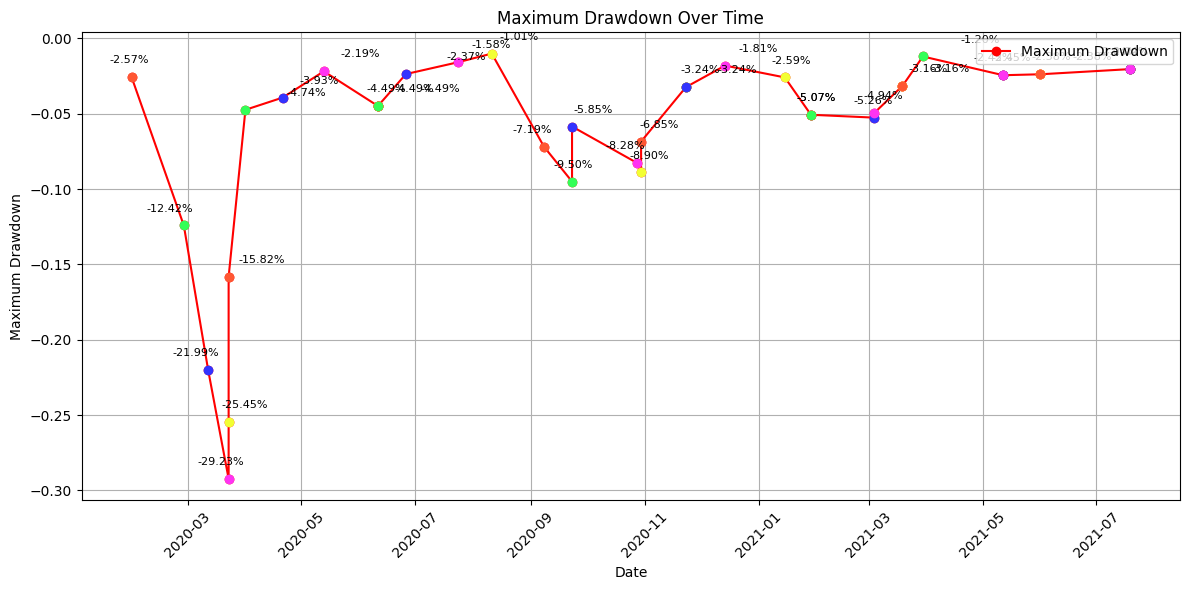

In [30]:
sparkling_colors = ['#ff5733', '#33ff57', '#3333ff', '#ff33f2', '#f2ff33']
plt.figure(figsize=(12, 6))
plt.plot(max_drawdown_start_dates, max_drawdown_values, marker='o', linestyle='-', color='red', label='Maximum Drawdown')
for i in range(len(max_drawdown_start_dates)):
    plt.plot(max_drawdown_start_dates[i], max_drawdown_values[i], marker='o', linestyle='', color=sparkling_colors[i % len(sparkling_colors)])
    plt.annotate(f'{max_drawdown_values[i]*100:.2f}%',
                 (max_drawdown_end_dates[i], max_drawdown_values[i]),
                 textcoords="offset points",
                 xytext=(-10,10),
                 ha='center',
                 fontsize=8)

plt.xlabel('Date')
plt.ylabel('Maximum Drawdown')
plt.title('Maximum Drawdown Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


##**Step 3**

In [31]:
def perform_test(returns, training_period, testing_period, function, shrinkage=None, method=None):
    pf_returns_df = pd.Series()
    weights_df = pd.DataFrame(columns=returns.columns)
    share_ratio = []
    for i in range(0, len(returns) - training_period - testing_period, testing_period):
        training_data = returns.iloc[i: i + training_period]
        testing_data = returns.iloc[i + training_period : i + training_period + testing_period]
        if shrinkage is not None:
            weights,sr = function(training_data, shrinkage=shrinkage, method=None)
        if method is not None:
            weights,sr = function(training_data, shrinkage=None, method=method)
        else:
            weights,sr = function(training_data)
        pf_returns_df = pd.concat([pf_returns_df, np.sum(testing_data * weights, axis=1)])
        weights_df.loc[testing_data.iloc[0].name] = weights
        share_ratio.append(sr)
    return pf_returns_df, weights_df,share_ratio

In [32]:
equal_returns, equal_weights, equal_sr = perform_test(returns, 30, 10, get_weights_equal)

In [33]:
tangency_returns, tangency_weights,tangency_sr = perform_test(returns, 30, 10, get_weights_tangency)

In [34]:
denoising_returns, denoising_weights,denoising_sr = perform_test(returns, 30, 10, get_weights_denoising, method='lw')

In [35]:
clustering_returns, clustering_weights,clustering_sr  = perform_test(returns, 30, 10, get_weights_clustering)

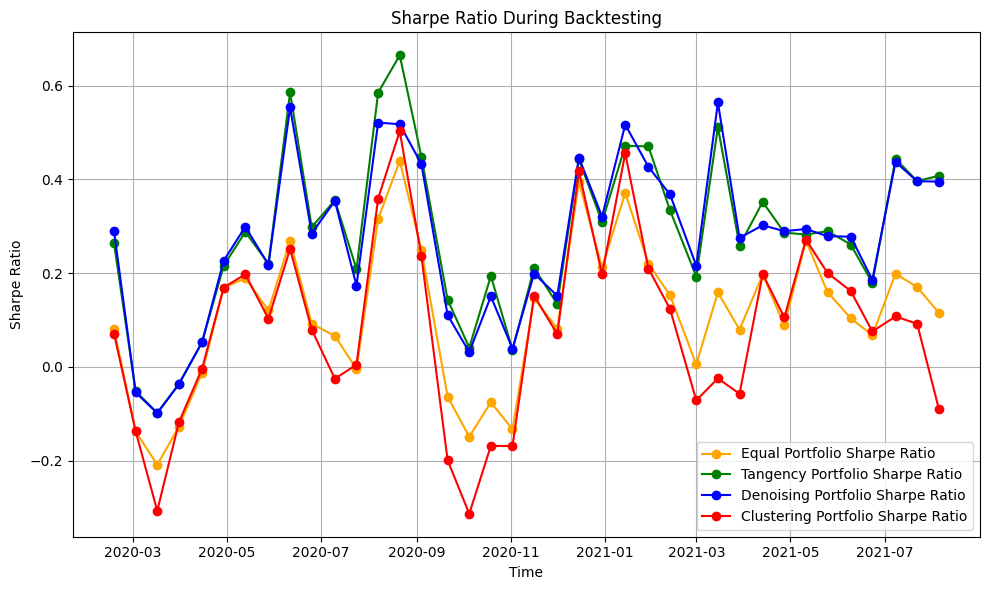

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(equal_weights.index,equal_sr, color='orange', marker='o', linestyle='-', label='Equal Portfolio Sharpe Ratio')
plt.plot(tangency_weights.index,tangency_sr, color='green', marker='o', linestyle='-', label='Tangency Portfolio Sharpe Ratio')
plt.plot(denoising_weights.index,denoising_sr, color='blue', marker='o', linestyle='-', label='Denoising Portfolio Sharpe Ratio')
plt.plot(clustering_weights.index,clustering_sr, color='red', marker='o', linestyle='-', label='Clustering Portfolio Sharpe Ratio')
plt.xlabel('Time')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio During Backtesting')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
equal_mean = np.mean(equal_sr)
tangency_mean = np.mean(tangency_sr)
denoising_mean = np.mean(denoising_sr)
clustering_mean = np.mean(clustering_sr)

# Print mean of every array
print("Mean of equal_sr:", equal_mean)
print("Mean of tangency_sr:", tangency_mean)
print("Mean of denoising_sr:", denoising_mean)
print("Mean of clustering_sr:", clustering_mean)

Mean of equal_sr: 0.11235956304006448
Mean of tangency_sr: 0.28022981816347764
Mean of denoising_sr: 0.2737588886944109
Mean of clustering_sr: 0.08224507716801362


In [38]:
pf_returns = pd.DataFrame()

pf_returns['tangency'] = tangency_returns
pf_returns['denoising'] = denoising_returns
pf_returns['equal'] = equal_returns
pf_returns['clustering'] = clustering_returns

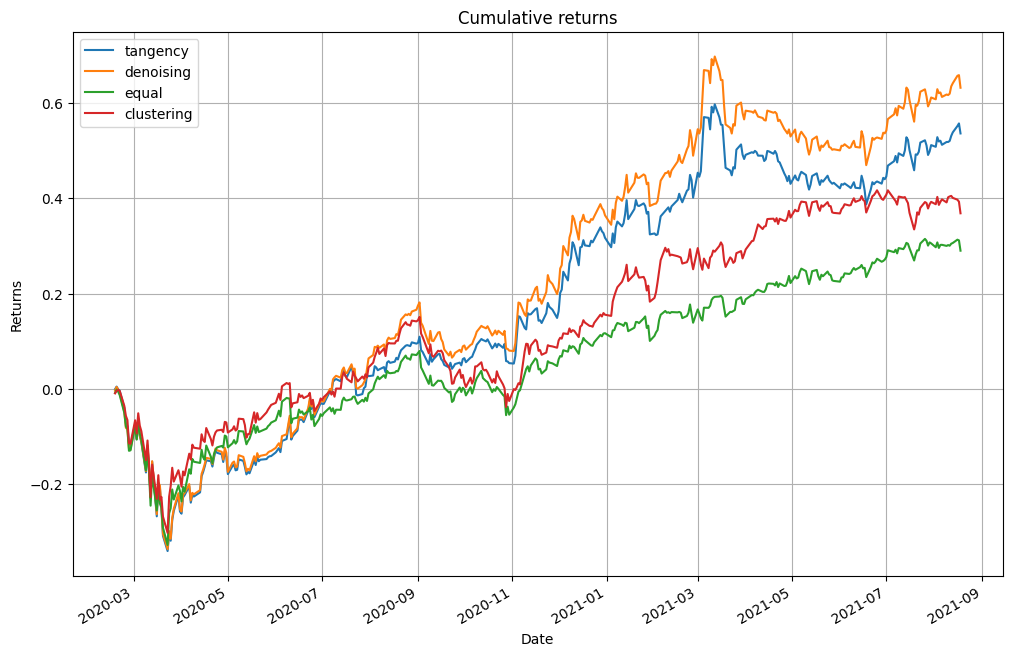

In [39]:
fig, ax = plt.subplots(figsize=(12,8))

((1 + pf_returns).cumprod() - 1).plot(ax=ax);
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.grid(True)
ax.set_title('Cumulative returns');

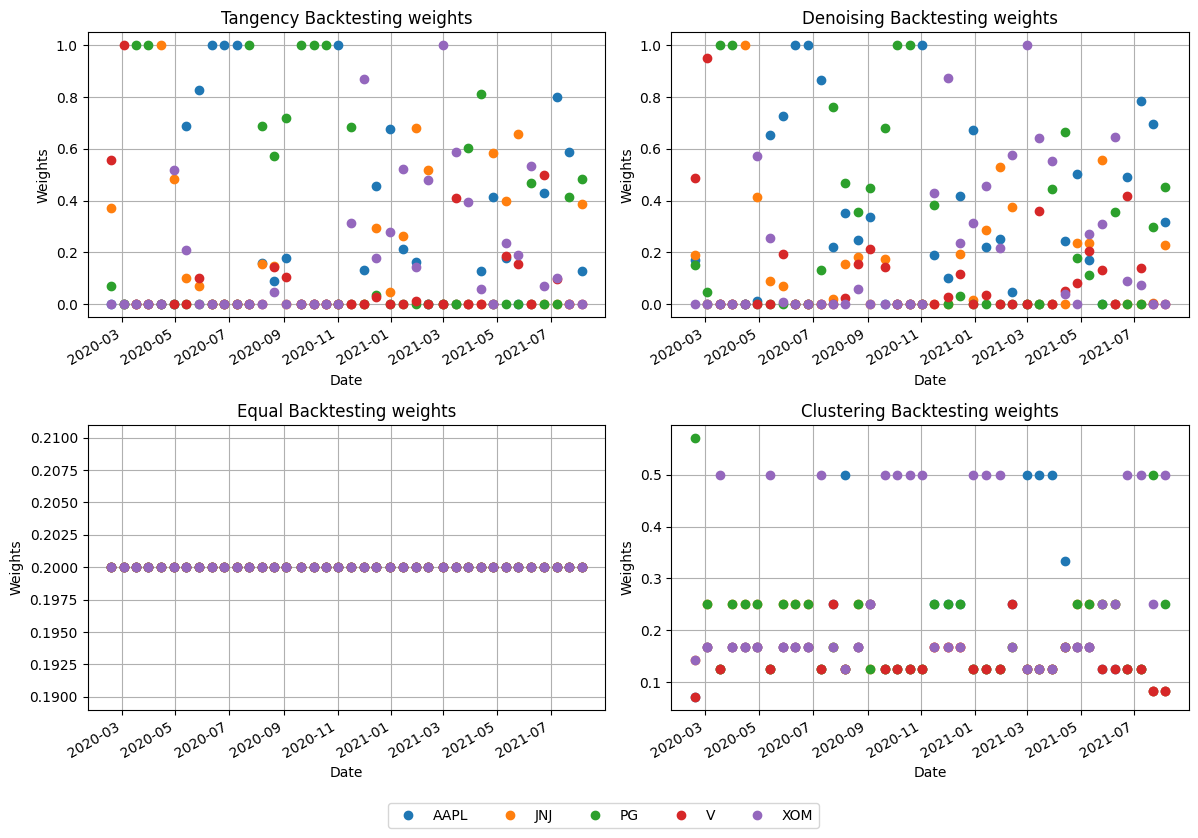

In [40]:
import matplotlib.pyplot as plt

# Define weights
weights = {'Tangency Backtesting weights': tangency_weights,
           'Denoising Backtesting weights': denoising_weights,
           'Equal Backtesting weights': equal_weights,
           'Clustering Backtesting weights': clustering_weights}

num_weights = len(weights)
num_cols = 2
num_rows = -(-num_weights // num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, (name, weight) in enumerate(weights.items()):
    row = i // num_cols
    col = i % num_cols
    weight.plot(marker='o', linestyle='', ax=axs[row, col])
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Weights')
    axs[row, col].set_title(name)
    axs[row, col].grid(True)
    axs[row, col].legend().remove()

# Remove empty subplot(s) if num_weights is not a multiple of num_cols
if num_rows * num_cols > num_weights:
    axs.flatten()[-1].remove()

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=weight.shape[1])

plt.tight_layout()
plt.show()


In [41]:
def calculate_max_drawdown(data, weights, window_size, step_size):
    max_drawdown_values = []
    max_drawdown_start_dates = []
    max_drawdown_end_dates = []

    for i in range(0, len(data) - window_size, step_size):
        window_data = data.iloc[i:i+window_size]

        # Calculate portfolio value with equal weights
        portfolio_value = (window_data * weights.mean()).sum(axis=1)
        initial_investment = 10000
        portfolio_value *= initial_investment / portfolio_value.iloc[0]  # Adjust to initial investment of $10,000

        # Calculate maximum drawdown
        rolling_max_portfolio = portfolio_value.cummax()
        daily_drawdown_portfolio = portfolio_value / rolling_max_portfolio - 1.0
        max_drawdown_portfolio = daily_drawdown_portfolio.cummin()

        # Find the maximum drawdown value and its date range
        max_drawdown_values.append(max_drawdown_portfolio.min())
        max_drawdown_start_dates.append(max_drawdown_portfolio.idxmin())
        max_drawdown_end_dates.append(portfolio_value.loc[max_drawdown_portfolio.idxmin():].idxmax())

    return pd.DataFrame({
        'Max_Drawdown_Value': max_drawdown_values,
        'Max_Drawdown_Start_Date': max_drawdown_start_dates,
        'Max_Drawdown_End_Date': max_drawdown_end_dates
    })

In [42]:
bt_tangency_result_df = calculate_max_drawdown(data, backtesting_weights, window_size, step_size)

In [43]:
bt_denoising_result_df = calculate_max_drawdown(data, denoising_weights, window_size, step_size)

In [44]:
bt_clustering_result_df = calculate_max_drawdown(data, clustering_weights, window_size, step_size)

In [45]:
bt_equal_result_df = calculate_max_drawdown(data, equal_weights, window_size, step_size)

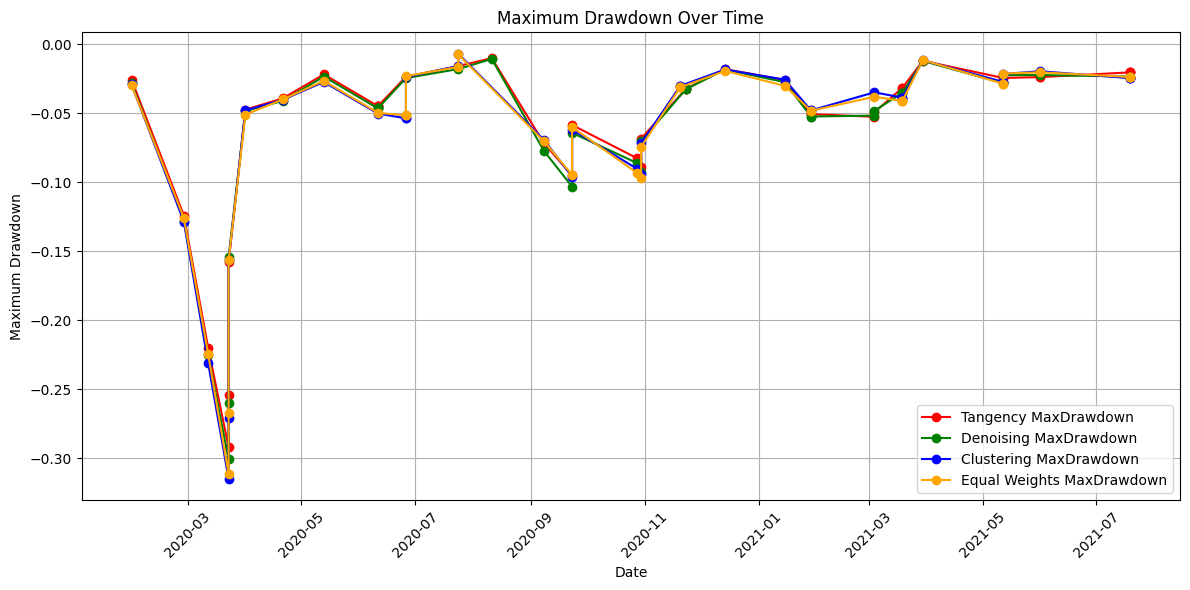

In [46]:
sparkling_colors = ['#ff5733', '#33ff57', '#3333ff', '#ff33f2', '#f2ff33']
plt.figure(figsize=(12, 6))
plt.plot(bt_tangency_result_df['Max_Drawdown_Start_Date'], bt_tangency_result_df['Max_Drawdown_Value'], marker='o', linestyle='-', color='red', label='Tangency MaxDrawdown')
plt.plot(bt_denoising_result_df['Max_Drawdown_Start_Date'], bt_denoising_result_df['Max_Drawdown_Value'], marker='o', linestyle='-', color='green', label='Denoising MaxDrawdown')
plt.plot(bt_clustering_result_df['Max_Drawdown_Start_Date'], bt_clustering_result_df['Max_Drawdown_Value'], marker='o', linestyle='-', color='blue', label='Clustering MaxDrawdown')
plt.plot(bt_equal_result_df['Max_Drawdown_Start_Date'], bt_equal_result_df['Max_Drawdown_Value'], marker='o', linestyle='-', color='orange', label='Equal Weights MaxDrawdown')



plt.xlabel('Date')
plt.ylabel('Maximum Drawdown')
plt.title('Maximum Drawdown Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

##**Step 4**

In [47]:
start_date = '2021-09-01'
end_date = '2021-09-15'

data_2wk,returns_2wk = retrieve_historical_data(tickers, start_date, end_date)

[*********************100%%**********************]  5 of 5 completed


In [48]:
pf_returns = pd.DataFrame()

pf_returns['tangency'] = (returns_2wk * tangency_weights.iloc[-1]).sum(axis=1)
pf_returns['denoising'] = (returns_2wk * denoising_weights.iloc[-1]).sum(axis=1)
pf_returns['equal'] = (returns_2wk * equal_weights.iloc[-1]).sum(axis=1)
pf_returns['clustering'] = (returns_2wk * clustering_weights.iloc[-1]).sum(axis=1)

####**Sharpe Ratio**

In [49]:
pf_sharpe_ratio = {}

for portfolio in ['tangency', 'denoising', 'equal', 'clustering']:
    portfolio_returns = pf_returns[portfolio]
    portfolio_std_dev = np.std(portfolio_returns)
    sharpe_ratio = (np.mean(portfolio_returns)) / portfolio_std_dev
    pf_sharpe_ratio[portfolio] = sharpe_ratio

pf_sharpe_ratio

{'tangency': -0.4511122199798227,
 'denoising': -0.3523386551250071,
 'equal': -0.38170655598526376,
 'clustering': 0.021250317870861502}

#### **Returns**

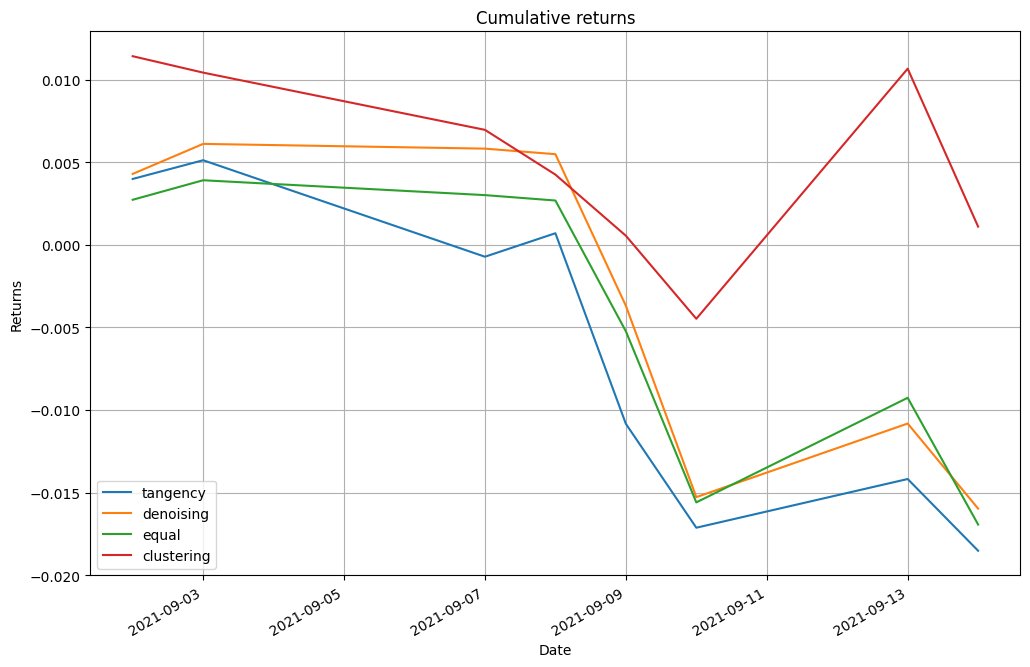

In [50]:
fig, ax = plt.subplots(figsize=(12,8))

((1 + pf_returns).cumprod() - 1).plot(ax=ax);
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.grid(True)
ax.set_title('Cumulative returns');

####**Max Drawdown**

In [51]:
def calculate_max_drawdown_2wk(data, weights):
    max_drawdown_values = []
    max_drawdown_start_dates = []
    max_drawdown_end_dates = []

    portfolio_value = (data * weights.mean()).sum(axis=1)
    initial_investment = 10000
    portfolio_value *= initial_investment / portfolio_value.iloc[0]  # Adjust to initial investment of $10,000

    # Calculate maximum drawdown
    rolling_max_portfolio = portfolio_value.cummax()
    daily_drawdown_portfolio = portfolio_value / rolling_max_portfolio - 1.0
    max_drawdown_portfolio = daily_drawdown_portfolio.cummin()

    # Find the maximum drawdown value and its date range
    max_drawdown_values.append(max_drawdown_portfolio.min())
    max_drawdown_start_dates.append(max_drawdown_portfolio.idxmin())
    max_drawdown_end_dates.append(portfolio_value.loc[max_drawdown_portfolio.idxmin():].idxmax())

    return pd.DataFrame({
        'Max_Drawdown_Value': max_drawdown_values,
        'Max_Drawdown_Start_Date': max_drawdown_start_dates,
        'Max_Drawdown_End_Date': max_drawdown_end_dates
    })

In [52]:
bt_tangency_result_df_2wk = calculate_max_drawdown_2wk(data_2wk, backtesting_weights)

In [53]:
bt_denoising_result_df_2wk = calculate_max_drawdown_2wk(data_2wk, denoising_weights)

In [54]:
bt_clustering_result_df_2wk = calculate_max_drawdown_2wk(data_2wk, clustering_weights)

In [55]:
bt_equal_result_df_2wk = calculate_max_drawdown_2wk(data_2wk, equal_weights)

In [56]:
bt_equal_result_df_2wk

,Max_Drawdown_Value,Max_Drawdown_Start_Date,Max_Drawdown_End_Date
0,-0.02517,2021-09-14,2021-09-14


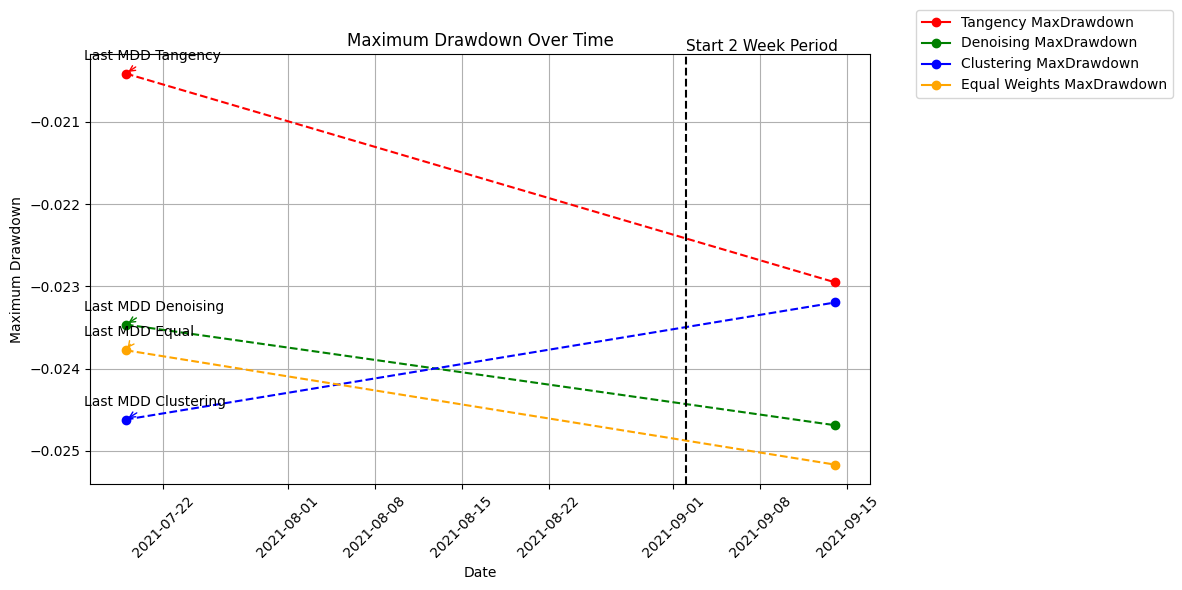

In [57]:

from datetime import datetime
last_point_tangency = bt_tangency_result_df.iloc[-1]
last_point_denoising = bt_denoising_result_df.iloc[-1]
last_point_clustering = bt_clustering_result_df.iloc[-1]
last_point_equal = bt_equal_result_df.iloc[-1]

first_point_tangency_2wk = bt_tangency_result_df_2wk.iloc[0]
first_point_denoising_2wk = bt_denoising_result_df_2wk.iloc[0]
first_point_clustering_2wk = bt_clustering_result_df_2wk.iloc[0]
first_point_equal_2wk = bt_equal_result_df_2wk.iloc[0]


plt.figure(figsize=(12, 6))
plt.plot(bt_tangency_result_df_2wk['Max_Drawdown_Start_Date'], bt_tangency_result_df_2wk['Max_Drawdown_Value'], marker='o', linestyle='-', color='red', label='Tangency MaxDrawdown')
plt.plot(bt_denoising_result_df_2wk['Max_Drawdown_Start_Date'], bt_denoising_result_df_2wk['Max_Drawdown_Value'], marker='o', linestyle='-', color='green', label='Denoising MaxDrawdown')
plt.plot(bt_clustering_result_df_2wk['Max_Drawdown_Start_Date'], bt_clustering_result_df_2wk['Max_Drawdown_Value'], marker='o', linestyle='-', color='blue', label='Clustering MaxDrawdown')
plt.plot(bt_equal_result_df_2wk['Max_Drawdown_Start_Date'], bt_equal_result_df_2wk['Max_Drawdown_Value'], marker='o', linestyle='-', color='orange', label='Equal Weights MaxDrawdown')


plt.plot([last_point_tangency['Max_Drawdown_Start_Date'], first_point_tangency_2wk['Max_Drawdown_Start_Date']],
         [last_point_tangency['Max_Drawdown_Value'], first_point_tangency_2wk['Max_Drawdown_Value']],
         linestyle='--', color='red')
plt.plot([last_point_denoising['Max_Drawdown_Start_Date'], first_point_denoising_2wk['Max_Drawdown_Start_Date']],
         [last_point_denoising['Max_Drawdown_Value'], first_point_denoising_2wk['Max_Drawdown_Value']],
         linestyle='--', color='green')
plt.plot([last_point_clustering['Max_Drawdown_Start_Date'], first_point_clustering_2wk['Max_Drawdown_Start_Date']],
         [last_point_clustering['Max_Drawdown_Value'], first_point_clustering_2wk['Max_Drawdown_Value']],
         linestyle='--', color='blue')
plt.plot([last_point_equal['Max_Drawdown_Start_Date'], first_point_equal_2wk['Max_Drawdown_Start_Date']],
         [last_point_equal['Max_Drawdown_Value'], first_point_equal_2wk['Max_Drawdown_Value']],
         linestyle='--', color='orange')
plt.scatter(last_point_tangency['Max_Drawdown_Start_Date'], last_point_tangency['Max_Drawdown_Value'], color='red')
plt.scatter(last_point_denoising['Max_Drawdown_Start_Date'], last_point_denoising['Max_Drawdown_Value'], color='green')
plt.scatter(last_point_clustering['Max_Drawdown_Start_Date'], last_point_clustering['Max_Drawdown_Value'], color='blue')
plt.scatter(last_point_equal['Max_Drawdown_Start_Date'], last_point_equal['Max_Drawdown_Value'], color='orange')
plt.annotate('Last MDD Tangency', xy=(last_point_tangency['Max_Drawdown_Start_Date'], last_point_tangency['Max_Drawdown_Value']), xytext=(-30, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))
plt.annotate('Last MDD Denoising', xy=(last_point_denoising['Max_Drawdown_Start_Date'], last_point_denoising['Max_Drawdown_Value']), xytext=(-30, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='green'))
plt.annotate('Last MDD Clustering', xy=(last_point_clustering['Max_Drawdown_Start_Date'], last_point_clustering['Max_Drawdown_Value']), xytext=(-30, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='blue'))
plt.annotate('Last MDD Equal', xy=(last_point_equal['Max_Drawdown_Start_Date'], last_point_equal['Max_Drawdown_Value']), xytext=(-30, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='orange'))
start_date = datetime.strptime('2021-09-02', '%Y-%m-%d')
plt.axvline(x=start_date, color='black', linestyle='--')

plt.text(start_date, plt.ylim()[1], 'Start 2 Week Period', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=11)


plt.xlabel('Date')
plt.ylabel('Maximum Drawdown')
plt.title('Maximum Drawdown Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='center left')

plt.tight_layout()

plt.show()
